# Magnet Distance Notes

This notebooks contains my notes on determining magnet distance from the magnetic flux value, as the relationship between them isn't linear. The calculations here are based on the datasheets from the DRV5056.

![Magnet Dimensions](./magnet-distance/magnet-dimensions.png)

This formula can then be used to calculate the magnetic flux:

![Magnetic Flux Formula](./magnet-distance/magnetic-flux-formula.png)

The DRV5056 datasheet provided this magnetic profile for a 10mm x 6mm cylindrical ferrite magnet as reference:

![10mm x 6mm Cylindrical Magnet Profile](./magnet-distance/10x6-cylindrical-magnet.png)

In [64]:
# Imports
import numpy as np
from matplotlib import pyplot as plt

[71.93230414 69.89590061 67.91416263 65.9865631  64.11247356 62.2911756
 60.52187166 58.80369523 57.13572043 55.51697103 53.94642869 52.42304075
 50.94572726 49.51338751 48.12490593 46.77915744 45.47501234 44.2113406
 42.98701579 41.80091846 40.65193926 39.53898149 38.46096351 37.41682065
 36.40550696 35.42599657 34.47728495 33.55838979 32.66835181 31.80623534
 30.9711287  30.16214451 29.37841984 28.61911623 27.88341966 27.17054036
 26.4797126  25.81019445 25.16126737 24.53223585 23.922427   23.33119006
 22.75789592 22.20193663 21.66272483 21.13969328 20.63229423 20.13999895
 19.66229714 19.19869636 18.74872152 18.31191431 17.88783267 17.47605027
 17.07615597 16.68775329 16.31045999 15.94390747 15.58774039 15.24161613
 14.90520439 14.57818671 14.26025607 13.95111648 13.65048254 13.35807908
 13.07364078 12.7969118  12.52764544 12.2656038  12.01055741 11.76228497
 11.52057303 11.28521568 11.05601426 10.83277712 10.61531934 10.40346246
 10.19703426  9.99586853  9.79980482  9.60868823  9.4

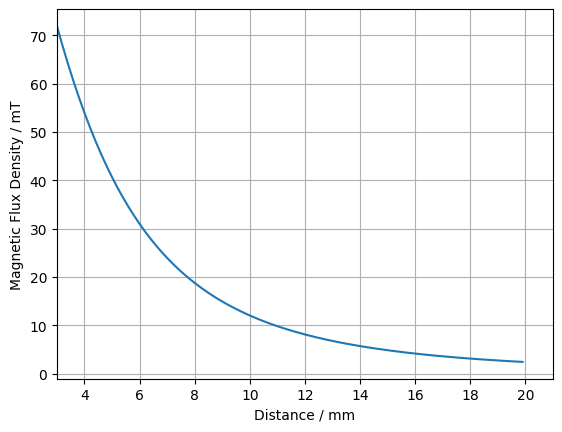

In [65]:
# Attempt to replicate the datasheet calculations
residual = 400 / 2.0    # In Millitesla
thickness = 6.0
diameter = 10.0
distances = np.arange(3, 20, 0.1)

radius_squared = (0.5 * diameter) ** 2

# Left fraction
lhs_numerator = distances + thickness
lhs_denominator = np.sqrt(radius_squared + (distances + thickness) ** 2)
lhs = lhs_numerator / lhs_denominator

# Right fraction
rhs_denominator = np.sqrt(radius_squared + (distances ** 2))
rhs = distances / rhs_denominator

# Calculate the final magnetic profile
magnetic_profile = residual * (lhs - rhs)

print(magnetic_profile)

plt.grid()
plt.xlim(3.0, 21.0)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, magnetic_profile)
plt.show()

[71.93230414 69.89590061 67.91416263 65.9865631  64.11247356 62.2911756
 60.52187166 58.80369523 57.13572043 55.51697103 53.94642869 52.42304075
 50.94572726 49.51338751 48.12490593 46.77915744 45.47501234 44.2113406
 42.98701579 41.80091846 40.65193926 39.53898149 38.46096351 37.41682065
 36.40550696 35.42599657 34.47728495 33.55838979 32.66835181 31.80623534
 30.9711287  30.16214451 29.37841984 28.61911623 27.88341966 27.17054036
 26.4797126  25.81019445 25.16126737 24.53223585 23.922427   23.33119006
 22.75789592 22.20193663 21.66272483 21.13969328 20.63229423 20.13999895
 19.66229714 19.19869636 18.74872152 18.31191431 17.88783267 17.47605027
 17.07615597 16.68775329 16.31045999 15.94390747 15.58774039 15.24161613
 14.90520439 14.57818671 14.26025607 13.95111648 13.65048254 13.35807908
 13.07364078 12.7969118  12.52764544 12.2656038  12.01055741 11.76228497
 11.52057303 11.28521568 11.05601426 10.83277712 10.61531934 10.40346246
 10.19703426  9.99586853  9.79980482  9.60868823  9.4

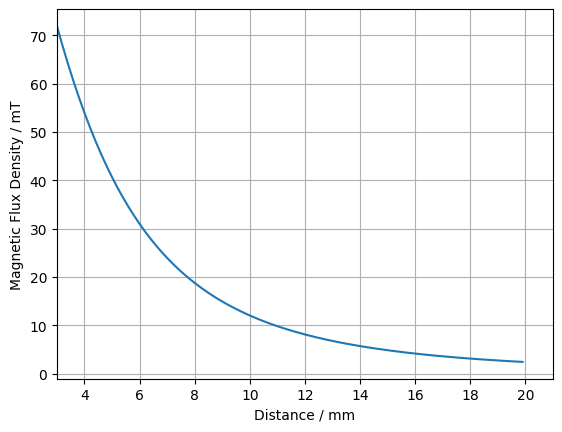

In [66]:
# Convert this into a re-usable function
def get_cylindrical_magnetic_profile(residual, thickness, diameter, distances):
    """ Function to calculate the magnetic profile for a cylindrical magnet. """
    residual = residual / 2.0
    radius_squared = (diameter / 2.0) ** 2
    
    # Left fraction
    lhs_numerator = distances + thickness
    lhs_denominator = np.sqrt(radius_squared + (distances + thickness) ** 2)
    lhs = lhs_numerator / lhs_denominator

    # Right fraction
    rhs_denominator = np.sqrt(radius_squared + (distances ** 2))
    rhs = distances / rhs_denominator

    return residual * (lhs - rhs)

distances = np.arange(3.0, 20.0, 0.1)
datasheet_profile = get_cylindrical_magnetic_profile(400, 6.0, 10.0, distances)

print(datasheet_profile)

plt.grid()
plt.xlim(3.0, 21.0)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, datasheet_profile)
plt.show()

## KS-20 Magnetic Profile

- Cylindrical Permanent Magnet
  - Thickness: 3.5mm
  - Diameter: 2.8mm
- PCB Thickness: 1.6mm
- Hall Element Centre: 0.65mm from bottom of chip
- Distance from Hall Element Centre: [2.55mm, 6.55mm]
  - Initial Position: 0.3mm from top of switch

[87.90908825 84.76982067 81.7753864  78.91782356 76.18966012 73.58388227
 71.09390473 68.71354293 66.43698693 64.25877706 62.17378107 60.1771729
 58.26441273 56.43122848 54.67359845 52.98773524 51.37007063 49.81724158
 48.32607716 46.89358633 45.51694656 44.1934933  42.92071001 41.69621899
 40.51777279 39.38324618 38.29062864 37.23801744 36.22361107 35.24570316
 34.30267681 33.39299927 32.51521696 31.66795084 30.84989208 30.05979796
 29.29648808 28.55884083 27.84579002 27.15632174 26.48947149 25.84432136
 25.21999751 24.61566773 24.03053916 23.46385615 22.91489831 22.38297857
 21.86744143 21.36766128 20.88304087 20.41300981 19.95702318 19.51456021
 19.08512308 18.66823575 18.26344283 17.87030857 17.48841592 17.11736553
 16.75677494 16.40627775 16.06552283 15.73417357 15.41190722 15.09841422
 14.79339756 14.49657223 14.20766462 13.926412   13.65256205 13.38587235
 13.12610995 12.87305093 12.62648    12.38619013 12.15198214 11.92366442
 11.70105254 11.48396895 11.27224272]


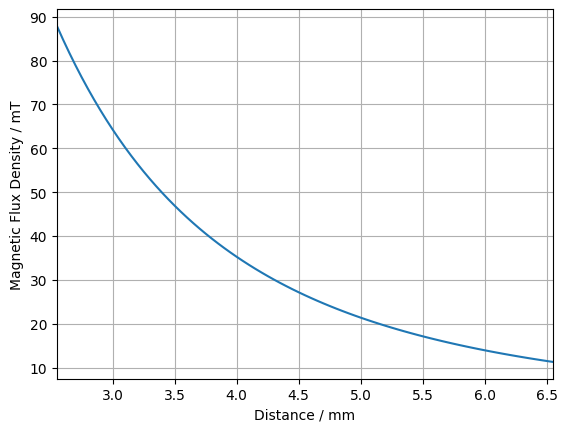

In [67]:
# At min distance (2.55mm), the magnetic flux is 905G, or 90.5mT
# At the initial position (6.25mm), the magnetic flux is 102G, or 10.2mT
#
# After using TI's calculator, it looks like the residual induction is between 1750 and 2000mT, but the values are off...
# If only we had the actual magnet specs...
remanance_mt = 1800
thickness = 3.5
diameter = 2.8

min_distance = 2.55
max_distance = 6.55
step = 0.05

distances = np.arange(min_distance, max_distance + step, step)
ks20_profile = get_cylindrical_magnetic_profile(remanance_mt, thickness, diameter, distances)

print(ks20_profile)

plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, ks20_profile)
plt.show()

[78.         78.         78.         78.         76.18966012 73.58388227
 71.09390473 68.71354293 66.43698693 64.25877706 62.17378107 60.1771729
 58.26441273 56.43122848 54.67359845 52.98773524 51.37007063 49.81724158
 48.32607716 46.89358633 45.51694656 44.1934933  42.92071001 41.69621899
 40.51777279 39.38324618 38.29062864 37.23801744 36.22361107 35.24570316
 34.30267681 33.39299927 32.51521696 31.66795084 30.84989208 30.05979796
 29.29648808 28.55884083 27.84579002 27.15632174 26.48947149 25.84432136
 25.21999751 24.61566773 24.03053916 23.46385615 22.91489831 22.38297857
 21.86744143 21.36766128 20.88304087 20.41300981 19.95702318 19.51456021
 19.08512308 18.66823575 18.26344283 17.87030857 17.48841592 17.11736553
 16.75677494 16.40627775 16.06552283 15.73417357 15.41190722 15.09841422
 14.79339756 14.49657223 14.20766462 13.926412   13.65256205 13.38587235
 13.12610995 12.87305093 12.62648    12.38619013 12.15198214 11.92366442
 11.70105254 11.48396895 11.27224272]


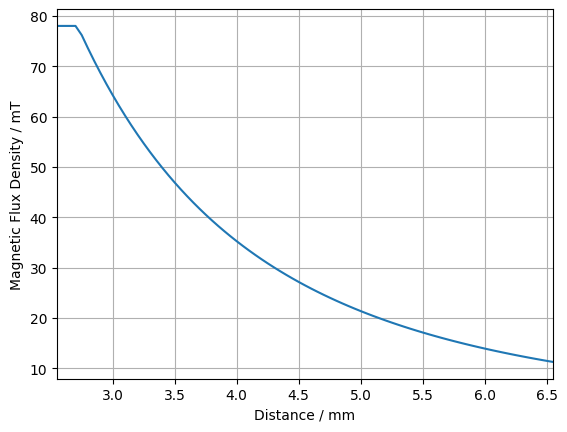

In [68]:
# If we clamp the maximum flux density to 78mT, we can find the minimum distance that can be detected
# In ideal conditions, we won't be able to detect the bottom 0.2mm of travel
ks20_profile_clamped = np.clip(ks20_profile, 0.0, 78.0)
print(ks20_profile_clamped)

plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('Magnetic Flux Density / mT')
plt.plot(distances, ks20_profile_clamped)
plt.show()

[3237.27264736 3143.09462024 3053.26159198 2967.53470671 2885.6898035
 2807.51646797 2732.81714182 2661.40628786 2593.10960803 2527.76331182
 2465.21343223 2405.31518698 2347.9323819  2292.93685428 2240.20795363
 2189.6320573  2141.10211894 2094.51724752 2049.78231486 2006.80758975
 1965.50839692 1925.80479903 1887.62130025 1850.88656973 1815.53318378
 1781.49738527 1748.71885922 1717.14052325 1686.70833207 1657.37109478
 1629.08030433 1601.78997807 1575.45650877 1550.03852533 1525.49676244
 1501.79393869 1478.89464245 1456.76522501 1435.37370054 1414.68965227
 1394.68414464 1375.32964082 1356.59992542 1338.47003195 1320.91617466
 1303.91568458 1287.44694944 1271.48935717 1256.02324275 1241.02983833
 1226.49122616 1212.39029436 1198.71069529 1185.43680625 1172.55369252
 1160.04707249 1147.90328479 1136.10925723 1124.65247758 1113.52096586
 1102.7032483  1092.18833264 1081.96568483 1072.02520697 1062.35721651
 1052.95242649 1043.8019269  1034.89716699 1026.22993855 1017.79236002
 1009.5

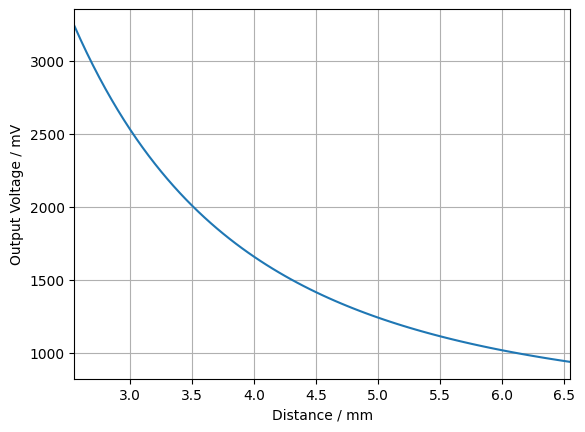

In [69]:
# Calculate the output voltage
quiescent_mv = 600
sensitivity_mv = 30
temperature = 25
ks20_mv = np.clip(quiescent_mv + ks20_profile * (sensitivity_mv * (1 + 0.0012 * (temperature - 25))), 0, 3300)

print(ks20_mv)
plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('Output Voltage / mV')
plt.plot(distances, ks20_mv)
plt.show()

[4018.14204957 3901.24714076 3789.74529719 3683.34004808 3581.75316216
 3484.72347055 3392.00576148 3303.36974396 3218.59907712 3137.49046218
 3059.85279346 2985.50636542 2914.28213219 2846.02101671 2780.57326608
 2717.79785051 2657.56190278 2599.74019572 2544.21465505 2490.87390534
 2439.6128466  2390.33225964 2342.93843813 2297.34284534 2253.46179417
 2211.21614851 2170.53104465 2131.33563129 2093.56282672 2057.14909219
 2022.03422016 1988.16113642 1955.47571513 1923.92660599 1893.46507242
 1864.04484027 1835.6219562  1808.15465504 1781.60323558 1755.92994415
 1731.09886559 1707.07582084 1683.82827107 1661.32522754 1639.53716709
 1618.43595274 1597.99475907 1578.18800211 1558.99127343 1540.38127812
 1522.33577646 1504.833529   1487.85424482 1471.37853285 1455.38785592
 1439.86448755 1424.79147106 1410.1525811  1395.93228732 1382.11572005
 1368.68863789 1355.63739712 1342.94892274 1330.61068113 1318.61065419
 1306.93731482 1295.57960382 1284.52690788 1273.76903888 1263.29621414
 1253.

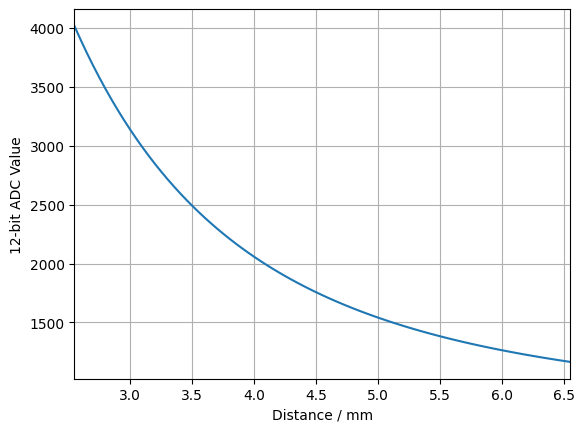

In [70]:
# Converting the voltages into 12-bit ADC values w/ 3.3V reference
ks20_adc = np.clip(4096 * (ks20_mv / 3300), 0, 4096)

print(ks20_adc)
plt.grid()
plt.xlim(min_distance, max_distance)
plt.xlabel('Distance / mm')
plt.ylabel('12-bit ADC Value')
plt.plot(distances, ks20_adc)
plt.show()

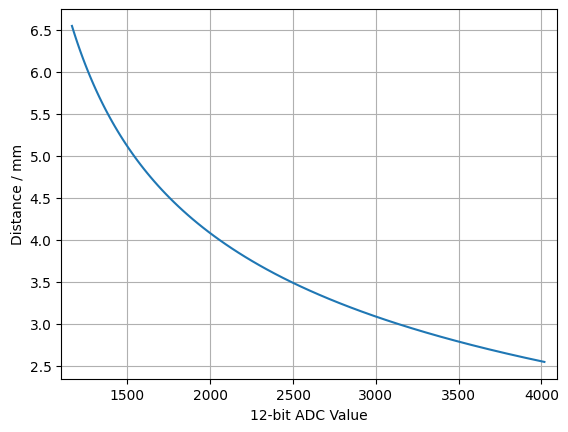

In [71]:
# If we plot in the other direction, we can come up with a lookup table for mapping ADC values -> distance
plt.grid()
plt.xlim(1100, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(ks20_adc, distances)
plt.show()

[1.44368451e+01 1.13910725e-03 2.57246871e+00]


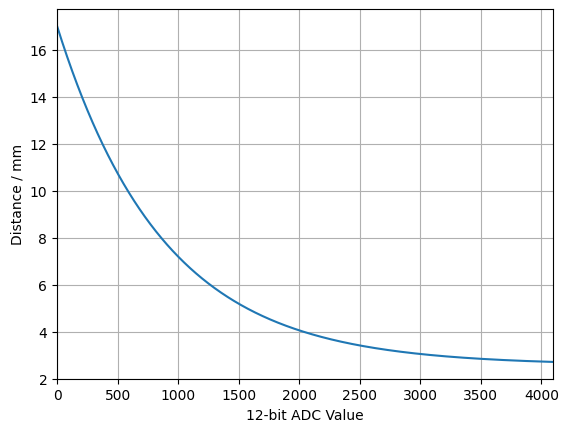

In [72]:
# An exponential function can be used for curve fitting
from scipy.optimize import curve_fit

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

popt, pcov = curve_fit(exponential_func, ks20_adc, distances, p0=(1, 0.001, 2.55))
print(popt)

x = np.arange(0.0, 4096.0, 1.0)
y = exponential_func(x, *popt)

plt.grid()
plt.xlim(0.0, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(x, y)

[   0.   16.   32.   48.   64.   80.   96.  112.  128.  144.  160.  176.
  192.  208.  224.  240.  256.  272.  288.  304.  320.  336.  352.  368.
  384.  400.  416.  432.  448.  464.  480.  496.  512.  528.  544.  560.
  576.  592.  608.  624.  640.  656.  672.  688.  704.  720.  736.  752.
  768.  784.  800.  816.  832.  848.  864.  880.  896.  912.  928.  944.
  960.  976.  992. 1008. 1024. 1040. 1056. 1072. 1088. 1104. 1120. 1136.
 1152. 1168. 1184. 1200. 1216. 1232. 1248. 1264. 1280. 1296. 1312. 1328.
 1344. 1360. 1376. 1392. 1408. 1424. 1440. 1456. 1472. 1488. 1504. 1520.
 1536. 1552. 1568. 1584. 1600. 1616. 1632. 1648. 1664. 1680. 1696. 1712.
 1728. 1744. 1760. 1776. 1792. 1808. 1824. 1840. 1856. 1872. 1888. 1904.
 1920. 1936. 1952. 1968. 1984. 2000. 2016. 2032. 2048. 2064. 2080. 2096.
 2112. 2128. 2144. 2160. 2176. 2192. 2208. 2224. 2240. 2256. 2272. 2288.
 2304. 2320. 2336. 2352. 2368. 2384. 2400. 2416. 2432. 2448. 2464. 2480.
 2496. 2512. 2528. 2544. 2560. 2576. 2592. 2608. 26

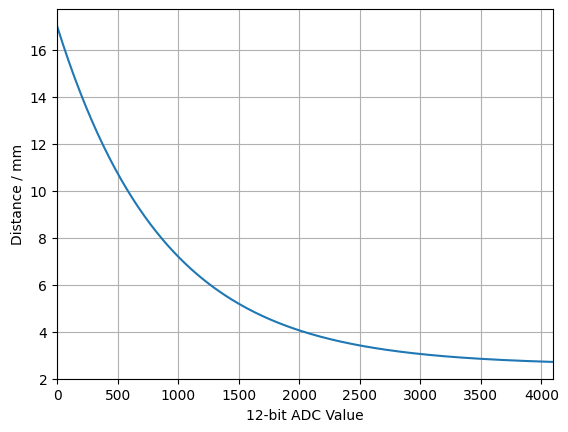

In [73]:
# A lookup table can then be generated from these values
# An extra value is needed for the maximum possible entry; this eliminates having to wrap around when performing lookups
lookup_bits = 4
lookup_step = 2 ** lookup_bits
lookup_x = np.arange(0, 4096.0 + lookup_step, lookup_step)
lookup_y = exponential_func(lookup_x, *popt)

print(lookup_x)
print(lookup_y)

plt.grid()
plt.xlim(0.0, 4096)
plt.xlabel('12-bit ADC Value')
plt.ylabel('Distance / mm')
plt.plot(lookup_x, lookup_y)

In [74]:
# Using the lookup table and linear interpolation, we can find the distance for a particular ADC value
# Max allowed value is 4095
def distance_lerp(adc):
    lut_index = int(adc / lookup_step)

    adc0 = lut_index * lookup_step
    adc1 = adc0 + lookup_step

    dist0 = lookup_y[lut_index]
    dist1 = lookup_y[lut_index + 1]

    distance_lerp = dist0 + (dist1 - dist0) * (adc - adc0) / lookup_step

    print('ADC Value:', adc)
    print('LUT Index:', lut_index)
    print(f'Between ({adc0}, {dist0}) and {adc1, dist1}')
    print('Interpolated Distance:', distance_lerp)

# These values can be used as the reference for top/bottom
distance_lerp(1142)
print()
distance_lerp(4095)

ADC Value: 1142
LUT Index: 71
Between (1136, 6.530543665003049) and (1152, 6.459058329133349)
Interpolated Distance: 6.503736664051911

ADC Value: 4095
LUT Index: 255
Between (4080, 2.710845631496573) and (4096, 2.7083464567422264)
Interpolated Distance: 2.708502655164373
